# AutoTSForecast Tutorial

Welcome to **AutoTSForecast v0.3.0** — an automated time series forecasting library with per-series model selection, uncertainty quantification, and visualization.

## What You'll Learn

| Part | Topic | What It Does |
|------|-------|-------------|
| 1 | Data Setup | Generate sample data and preview |
| 2 | AutoForecaster | Automatic per-series model selection |
| 3 | Calendar Features | Time-based feature extraction |
| 4 | Per-Series Covariates | Different features for different series |
| 4.5 | Chronos-2 Foundation Model | Zero-shot forecasting with state-of-the-art models |
| 5 | Prediction Intervals | Uncertainty quantification |
| 6 | Visualization | Static and interactive plots |
| 7 | Parallel Processing | Speed up multi-series forecasting |
| 8 | Hierarchical Reconciliation | Coherent forecasts across levels |
| 9 | Interpretability | Feature importance analysis |

## Documentation

- [API Reference](../API_REFERENCE.md) | [Quick Start](../QUICKSTART.md) | [Parameter Guide](../PARAMETER_GUIDE.md)

In [1]:
# Setup and Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Numpy compatibility
if not hasattr(np, 'trapz') and hasattr(np, 'trapezoid'):
    np.trapz = np.trapezoid
if not hasattr(np, 'in1d') and hasattr(np, 'isin'):
    np.in1d = np.isin

# AutoTSForecast imports
from autotsforecast import AutoForecaster
from autotsforecast.models.base import LinearForecaster, MovingAverageForecaster, VARForecaster
from autotsforecast.models.external import (
    ARIMAForecaster, ETSForecaster, ProphetForecaster,
    XGBoostForecaster, RandomForestForecaster, Chronos2Forecaster
)

# Helper functions
def rmse(y_true, y_pred):
    return float(np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred))**2)))

def mape(y_true, y_pred):
    return float(np.mean(np.abs((np.asarray(y_true) - np.asarray(y_pred)) / 
                                  (np.abs(np.asarray(y_true)) + 1e-9))) * 100)

np.random.seed(42)
print('Setup complete!')

Setup complete!


## Part 1: Data Setup

We create a retail sales dataset with:
- **3 time series**: `region_a`, `region_b`, `total` (hierarchical: total = region_a + region_b)
- **2 covariates**: `temperature`, `promotion`
- **240 days** of data with a 14-day forecast horizon

In [ ]:
# Generate Sample Dataset
np.random.seed(42)
n_days, horizon = 240, 14
dates = pd.date_range('2023-01-01', periods=n_days, freq='D')
t = np.arange(n_days)

# Covariates
temperature = 20 + 8 * np.sin(2 * np.pi * t / 7) + np.random.normal(0, 0.8, n_days)
promo = (np.random.rand(n_days) < 0.12).astype(int)
promo[-horizon:] = (np.random.rand(horizon) < 0.45).astype(int)

X = pd.DataFrame({'temperature': temperature, 'promotion': promo}, index=dates)

# DGP: Each series has DISTINCT drivers (enables per-series covariate benefits)
# Region A: driven by PROMOTION only (temperature is noise)
# Region B: driven by TEMPERATURE only (promotion is noise)
shared_noise = np.random.normal(0, 12.0, n_days)

region_a = (80 + 0.15*t + 8*np.sin(2*np.pi*t/7) 
            + 50*promo                    # Strong promotion effect
            + 0*temperature               # NO temperature effect
            + shared_noise + np.random.normal(0, 8, n_days))

region_b = (30 + 0.12*t + 5*np.sin(2*np.pi*t/30) 
            + 0*promo                     # NO promotion effect  
            + 3.5*temperature             # Strong temperature effect
            + np.random.normal(0, 3, n_days))

y = pd.DataFrame({
    'region_a': region_a, 'region_b': region_b, 'total': region_a + region_b
}, index=dates)

# Train/test split
y_train, y_test = y.iloc[:-horizon], y.iloc[-horizon:]
X_train, X_test = X.iloc[:-horizon], X.iloc[-horizon:]

print(f'Training: {len(y_train)} days | Test: {len(y_test)} days')
print('\nDGP Design:')
print('  Region A: 50*promotion + 0*temperature (promotion-driven)')
print('  Region B: 0*promotion + 3.5*temperature (temperature-driven)')

Training: 226 days | Test: 14 days

DGP Design:
  Region A: 50*promotion + 0*temperature (promotion-driven)
  Region B: 0*promotion + 3.5*temperature (temperature-driven)


In [3]:
# Preview the Data
print('=== TARGET SERIES (y) ===')
print(y.head(10).to_string())
print(f'\n... ({len(y)} rows total)\n')

print('=== COVARIATES (X) ===')
print(X.head(10).to_string())
print(f'\n... ({len(X)} rows total)')

=== TARGET SERIES (y) ===
              region_a    region_b       total
2023-01-01   71.493335  103.327252  174.820588
2023-01-02  124.031833  129.153464  253.185297
2023-01-03  133.869003  130.461858  264.330861
2023-01-04   42.863162  120.369606  163.232767
2023-01-05   71.154547   92.139501  163.294048
2023-01-06   78.589557   81.708922  160.298479
2023-01-07   81.413539   87.719910  169.133450
2023-01-08   75.716604  108.798491  184.515095
2023-01-09   98.113432  128.333052  226.446484
2023-01-10   86.606369  135.212260  221.818629

... (240 rows total)

=== COVARIATES (X) ===
            temperature  promotion
2023-01-01    20.397371          0
2023-01-02    26.144040          1
2023-01-03    28.317574          1
2023-01-04    24.689494          0
2023-01-05    16.341607          0
2023-01-06    12.013267          0
2023-01-07    15.008718          0
2023-01-08    20.613948          0
2023-01-09    25.879072          0
2023-01-10    28.233471          0

... (240 rows total)


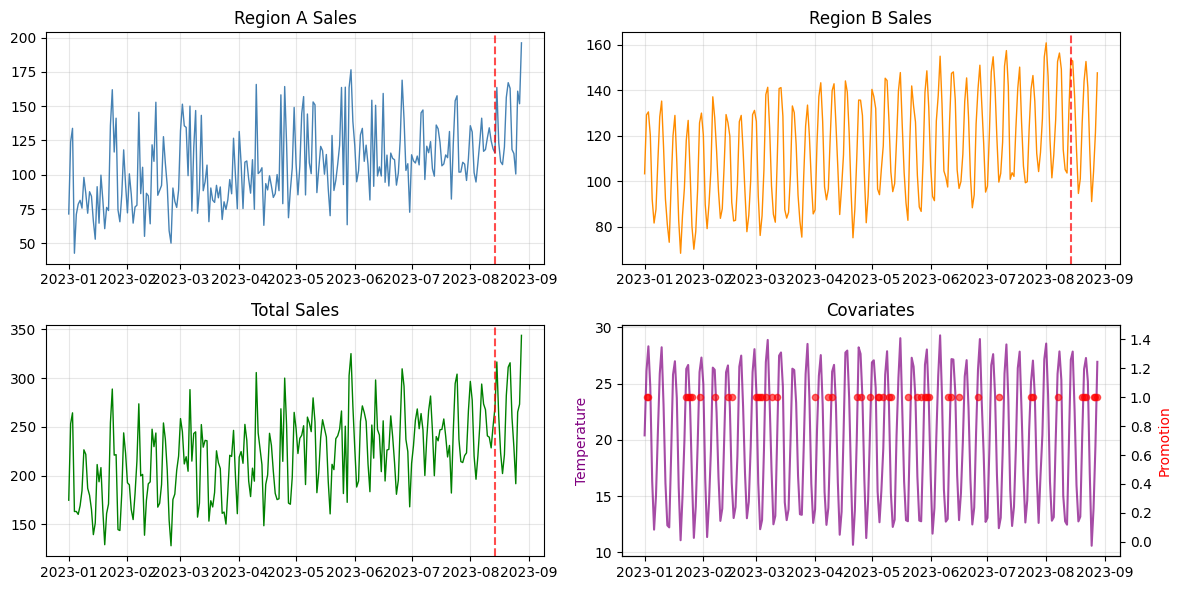

Red dashed line = train/test split


In [4]:
# Visualize the Data
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

for ax, (name, color) in zip(axes[0], [('region_a', 'steelblue'), ('region_b', 'darkorange')]):
    ax.plot(y.index, y[name], color=color, linewidth=1)
    ax.axvline(y_train.index[-1], color='red', linestyle='--', alpha=0.7)
    ax.set_title(f'{name.replace("_", " ").title()} Sales')
    ax.grid(alpha=0.3)

axes[1, 0].plot(y.index, y['total'], color='green', linewidth=1)
axes[1, 0].axvline(y_train.index[-1], color='red', linestyle='--', alpha=0.7)
axes[1, 0].set_title('Total Sales')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].plot(X.index, X['temperature'], color='purple', alpha=0.7)
axes[1, 1].set_ylabel('Temperature', color='purple')
ax2 = axes[1, 1].twinx()
ax2.scatter(X[X['promotion']==1].index, X[X['promotion']==1]['promotion'], color='red', s=20, alpha=0.6)
ax2.set_ylabel('Promotion', color='red')
ax2.set_ylim(-0.1, 1.5)
axes[1, 1].set_title('Covariates')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
print('Red dashed line = train/test split')

## Part 2: AutoForecaster — Per-Series Model Selection

AutoForecaster automatically selects the best model for **each series** using cross-validation.

In [5]:
# Define candidate models (including Chronos-2 foundation model)
candidates = [
    ARIMAForecaster(horizon=horizon),
    ETSForecaster(horizon=horizon),
    XGBoostForecaster(horizon=horizon, n_lags=14, n_estimators=100),
    RandomForestForecaster(horizon=horizon, n_lags=14, n_estimators=100),
    MovingAverageForecaster(horizon=horizon, window=7),
    Chronos2Forecaster(horizon=horizon, model_name='autogluon/chronos-2-small'),  # Zero-shot foundation model
]

# AutoForecaster with per-series selection
auto = AutoForecaster(
    candidate_models=candidates,
    per_series_models=True,
    n_splits=3,
    test_size=horizon,
    metric='rmse',
    verbose=False
)

print('Training AutoForecaster...')
auto.fit(y_train, X=X_train)

print('\nBest model per series:')
for series, model in auto.best_models_.items():
    print(f'  {series}: {type(model).__name__.replace("Forecaster", "")}')
    
print('\nNote: Chronos2 is a zero-shot foundation model - no training required!')

Training AutoForecaster...

Best model per series:
  region_a: XGBoost
  region_b: Chronos2
  total: Chronos2

Note: Chronos2 is a zero-shot foundation model - no training required!


In [6]:
# Generate forecasts and evaluate
forecasts = auto.forecast(X=X_test)

print('AutoForecaster Test Results:')
print(f'{"Series":<12} {"RMSE":<10} {"MAPE":<10}')
print('-' * 32)
for s in ['region_a', 'region_b', 'total']:
    print(f'{s:<12} {rmse(y_test[s], forecasts[s]):<10.2f} {mape(y_test[s], forecasts[s]):<10.1f}%')

AutoForecaster Test Results:
Series       RMSE       MAPE      
--------------------------------
region_a     16.09      6.7       %
region_b     4.34       2.8       %
total        28.37      8.5       %


## Part 3: Calendar Features

Automatically extract time-based features with cyclical encoding.

**Note**: Calendar features help when your data has actual calendar patterns (e.g., day-of-week effects, monthly seasonality). In this synthetic dataset, there are no true calendar patterns, so adding these features may not improve (or could worsen) accuracy. In real-world retail, weather, or web traffic data, calendar features often provide significant gains.

In [7]:
from autotsforecast.features.calendar import CalendarFeatures

# Auto-detect calendar features
cal = CalendarFeatures(cyclical_encoding=True)
cal_features = cal.fit_transform(y_train)

print('Auto-detected calendar features:')
print(cal_features.head())

# Custom features with Fourier terms
cal_custom = CalendarFeatures(
    features=['dayofweek', 'month', 'is_weekend'],
    fourier_terms={'weekly': (7, 2)},
    cyclical_encoding=True
)
custom_features = cal_custom.fit_transform(y_train)
print(f'\nCustom features: {list(custom_features.columns)}')

# Now USE calendar features by combining them with existing covariates
# Important: Use the SAME feature extractor (cal) for both train and test
X_train_with_cal = pd.concat([X_train, cal_features], axis=1)
X_test_cal = cal.transform_future(horizon=horizon, start=X_test.index[0])
X_test_with_cal = pd.concat([X_test, X_test_cal], axis=1)

print(f'\nOriginal covariates: {list(X_train.columns)}')
print(f'With calendar features: {list(X_train_with_cal.columns)}')

# Train model with calendar features included
auto_with_cal = AutoForecaster(
    candidate_models=[
        XGBoostForecaster(horizon=horizon, n_lags=7, n_estimators=100),
        RandomForestForecaster(horizon=horizon, n_lags=7, n_estimators=100),
    ],
    per_series_models=True,
    n_splits=3,
    metric='rmse',
    verbose=False
)

print('\nTraining with calendar features...')
auto_with_cal.fit(y_train, X=X_train_with_cal)
forecasts_with_cal = auto_with_cal.forecast(X=X_test_with_cal)

# Compare performance
print('\nPerformance comparison (with vs without calendar features):')
print(f'{"Series":<12} {"Without Cal":<12} {"With Cal":<12} {"Improvement":<12}')
print('-' * 48)
for s in y_train.columns:
    rmse_orig = rmse(y_test[s], forecasts[s])
    rmse_cal = rmse(y_test[s], forecasts_with_cal[s])
    improvement = (rmse_orig - rmse_cal) / rmse_orig * 100
    print(f'{s:<12} {rmse_orig:<12.2f} {rmse_cal:<12.2f} {improvement:>+.1f}%')

Auto-detected calendar features:
            dayofyear_sin  dayofyear_cos  month_sin  month_cos  quarter  \
2023-01-01       0.017166       0.999853        0.5   0.866025        1   
2023-01-02       0.034328       0.999411        0.5   0.866025        1   
2023-01-03       0.051479       0.998674        0.5   0.866025        1   
2023-01-04       0.068615       0.997643        0.5   0.866025        1   
2023-01-05       0.085731       0.996318        0.5   0.866025        1   

            dayofweek_sin  dayofweek_cos  is_weekend  dayofmonth  
2023-01-01      -0.781831       0.623490           1           1  
2023-01-02       0.000000       1.000000           0           2  
2023-01-03       0.781831       0.623490           0           3  
2023-01-04       0.974928      -0.222521           0           4  
2023-01-05       0.433884      -0.900969           0           5  

Custom features: ['dayofweek_sin', 'dayofweek_cos', 'month_sin', 'month_cos', 'is_weekend', 'weekly_sin_1', 'week

## Part 4: Per-Series Covariates

Different series may have **distinct drivers**. In our DGP:
- **Region A**: Driven by `promotion` only (temperature is irrelevant noise)
- **Region B**: Driven by `temperature` only (promotion is irrelevant noise)

Using per-series covariates lets each model focus on its true driver, avoiding overfitting to noise.

In [8]:
# Create per-series covariates: different features for each series
# Region A responds mainly to promotions, Region B to temperature
per_series_X_train = {
    'region_a': X_train[['promotion']],           # Region A: promotion only
    'region_b': X_train[['temperature']],         # Region B: temperature only
    'total': X_train[['temperature', 'promotion']] # Total: both features
}

per_series_X_test = {
    'region_a': X_test[['promotion']],
    'region_b': X_test[['temperature']],
    'total': X_test[['temperature', 'promotion']]
}

# AutoForecaster with per-series covariates
# Pass a dict to X instead of a DataFrame for per-series covariates
auto_per_cov = AutoForecaster(
    candidate_models=[
        XGBoostForecaster(horizon=horizon, n_lags=14, n_estimators=100),
        RandomForestForecaster(horizon=horizon, n_lags=14, n_estimators=100),
    ],
    per_series_models=True,
    n_splits=3,
    metric='rmse',
    verbose=False
)

print('Training with per-series covariates...')
auto_per_cov.fit(y_train, X=per_series_X_train)  # Pass dict to X parameter

# Forecast with per-series covariates
forecasts_per_cov = auto_per_cov.forecast(X=per_series_X_test)  # Pass dict to X parameter

print('\nResults with Per-Series Covariates:')
print(f'{"Series":<12} {"Shared X":<12} {"Per-Series X":<12} {"Improvement":<12}')
print('-' * 48)
for s in ['region_a', 'region_b', 'total']:
    shared_rmse = rmse(y_test[s], forecasts[s])
    per_series_rmse = rmse(y_test[s], forecasts_per_cov[s])
    improvement = (shared_rmse - per_series_rmse) / shared_rmse * 100
    print(f'{s:<12} {shared_rmse:<12.2f} {per_series_rmse:<12.2f} {improvement:>+.1f}%')

print('\n' + '='*60)
print('BONUS: Combining Per-Series Covariates + Calendar Features')
print('='*60)

# Combine per-series covariates WITH calendar features
# Each series gets its own relevant covariates PLUS calendar features
per_series_X_train_cal = {
    'region_a': pd.concat([X_train[['promotion']], cal_features], axis=1),
    'region_b': pd.concat([X_train[['temperature']], cal_features], axis=1),
    'total': pd.concat([X_train[['temperature', 'promotion']], cal_features], axis=1)
}

per_series_X_test_cal = {
    'region_a': pd.concat([X_test[['promotion']], X_test_cal], axis=1),
    'region_b': pd.concat([X_test[['temperature']], X_test_cal], axis=1),
    'total': pd.concat([X_test[['temperature', 'promotion']], X_test_cal], axis=1)
}

# Train with per-series covariates + calendar features
auto_per_cov_cal = AutoForecaster(
    candidate_models=[
        XGBoostForecaster(horizon=horizon, n_lags=7, n_estimators=100),
        RandomForestForecaster(horizon=horizon, n_lags=7, n_estimators=100),
    ],
    per_series_models=True,
    n_splits=3,
    metric='rmse',
    verbose=False
)

print('\nTraining with per-series covariates + calendar features...')
auto_per_cov_cal.fit(y_train, X=per_series_X_train_cal)
forecasts_per_cov_cal = auto_per_cov_cal.forecast(X=per_series_X_test_cal)

print('\nResults (Per-Series Covariates vs Per-Series + Calendar):')
print(f'{"Series":<12} {"Per-Series":<12} {"+ Calendar":<12} {"Improvement":<12}')
print('-' * 48)
for s in y_train.columns:
    per_cov_rmse = rmse(y_test[s], forecasts_per_cov[s])
    per_cov_cal_rmse = rmse(y_test[s], forecasts_per_cov_cal[s])
    improvement = (per_cov_rmse - per_cov_cal_rmse) / per_cov_rmse * 100
    print(f'{s:<12} {per_cov_rmse:<12.2f} {per_cov_cal_rmse:<12.2f} {improvement:>+.1f}%')

print('\nKey insight: Calendar features can be combined with per-series covariates!')
print('Each series gets its own domain-specific features PLUS shared calendar info.')

Training with per-series covariates...

Results with Per-Series Covariates:
Series       Shared X     Per-Series X Improvement 
------------------------------------------------
region_a     16.09        18.74        -16.5%
region_b     4.34         17.70        -307.6%
total        28.37        25.31        +10.8%

BONUS: Combining Per-Series Covariates + Calendar Features

Training with per-series covariates + calendar features...

Results (Per-Series Covariates vs Per-Series + Calendar):
Series       Per-Series   + Calendar   Improvement 
------------------------------------------------
region_a     18.74        19.04        -1.6%
region_b     17.70        14.93        +15.6%
total        25.31        24.98        +1.3%

Key insight: Calendar features can be combined with per-series covariates!
Each series gets its own domain-specific features PLUS shared calendar info.


## Part 4.5: Chronos-2 Foundation Model — Zero-Shot Forecasting

Chronos-2 is a state-of-the-art foundation model that requires **no training** - just pass your data and get predictions!

**Key Benefits:**
- 🚀 **Zero-shot learning**: Pre-trained on 100+ billion time series tokens
- 🌍 **Domain agnostic**: Works across retail, finance, weather, energy, etc.
- 🔮 **Probabilistic**: Get full prediction distributions with uncertainty
- ⚡ **Fast**: No training time required!

In [9]:
# Use Chronos-2 standalone (no AutoForecaster)
from autotsforecast.models.external import Chronos2Forecaster

# Initialize with small model for fast inference
chronos = Chronos2Forecaster(
    horizon=horizon,
    model_name='autogluon/chronos-2-small'  # 28M params, balanced speed/accuracy
)

print('Fitting Chronos-2 (just stores context, no training)...')
chronos.fit(y_train)

# Generate forecasts
chronos_forecasts = chronos.predict()

# Get probabilistic forecasts with quantiles
chronos_quantiles = chronos.predict_quantiles(quantile_levels=[0.1, 0.5, 0.9])

# Evaluate
print('\nChronos-2 Performance:')
print(f'{"Series":<12} {"RMSE":<12} {"MAPE":<12}')
print('-' * 36)
for s in y_train.columns:
    r = rmse(y_test[s], chronos_forecasts[s])
    m = mape(y_test[s], chronos_forecasts[s])
    print(f'{s:<12} {r:<12.2f} {m:<12.2f}%')

print('\nAvailable model sizes:')
print('  • autogluon/chronos-2-small (28M) - Recommended')
print('  • amazon/chronos-2 (120M) - Best accuracy')
print('  • amazon/chronos-bolt-tiny (9M) - Fastest')
print('  • amazon/chronos-bolt-base (205M) - Production quality')

Fitting Chronos-2 (just stores context, no training)...

Chronos-2 Performance:
Series       RMSE         MAPE        
------------------------------------
region_a     33.01        16.61       %
region_b     4.34         2.79        %
total        28.37        8.47        %

Available model sizes:
  • autogluon/chronos-2-small (28M) - Recommended
  • amazon/chronos-2 (120M) - Best accuracy
  • amazon/chronos-bolt-tiny (9M) - Fastest
  • amazon/chronos-bolt-base (205M) - Production quality


## Part 5: Prediction Intervals

Generate prediction intervals using conformal prediction.

In [10]:
from autotsforecast.uncertainty.intervals import PredictionIntervals

# Train model and generate point forecasts
model = RandomForestForecaster(horizon=horizon, n_lags=14)
model.fit(y_train[['region_a']], X=X_train)
preds = model.predict(X=X_test)

# Create 80% and 95% prediction intervals
pi = PredictionIntervals(method='conformal', coverage=[0.80, 0.95])
pi.fit(model, y_train[['region_a']])
intervals = pi.predict(preds)

# Assign proper datetime index
for key in intervals:
    intervals[key].index = y_test.index[:len(intervals[key])]

print('Prediction Intervals (first 5 days):')
print(f'{"Day":<6} {"Lower 95%":<12} {"Forecast":<12} {"Upper 95%":<12} {"Actual":<12}')
print('-' * 54)
for i in range(5):
    print(f'{i+1:<6} {intervals["lower_95"]["region_a"].iloc[i]:<12.1f} '
          f'{intervals["point"]["region_a"].iloc[i]:<12.1f} '
          f'{intervals["upper_95"]["region_a"].iloc[i]:<12.1f} '
          f'{y_test["region_a"].iloc[i]:<12.1f}')

# Coverage check
actual = y_test['region_a'].values
coverage = np.mean((actual >= intervals['lower_95']['region_a'].values) & 
                   (actual <= intervals['upper_95']['region_a'].values))
print(f'\nEmpirical coverage (95% target): {coverage*100:.1f}%')

Prediction Intervals (first 5 days):
Day    Lower 95%    Forecast     Upper 95%    Actual      
------------------------------------------------------
1      56.4         121.7        187.0        163.6       
2      49.0         114.3        179.6        123.4       
3      52.4         117.7        183.0        109.6       
4      46.0         111.3        176.6        107.4       
5      44.8         110.1        175.4        120.3       

Empirical coverage (95% target): 100.0%


## Part 6: Visualization

Create publication-ready plots with matplotlib.

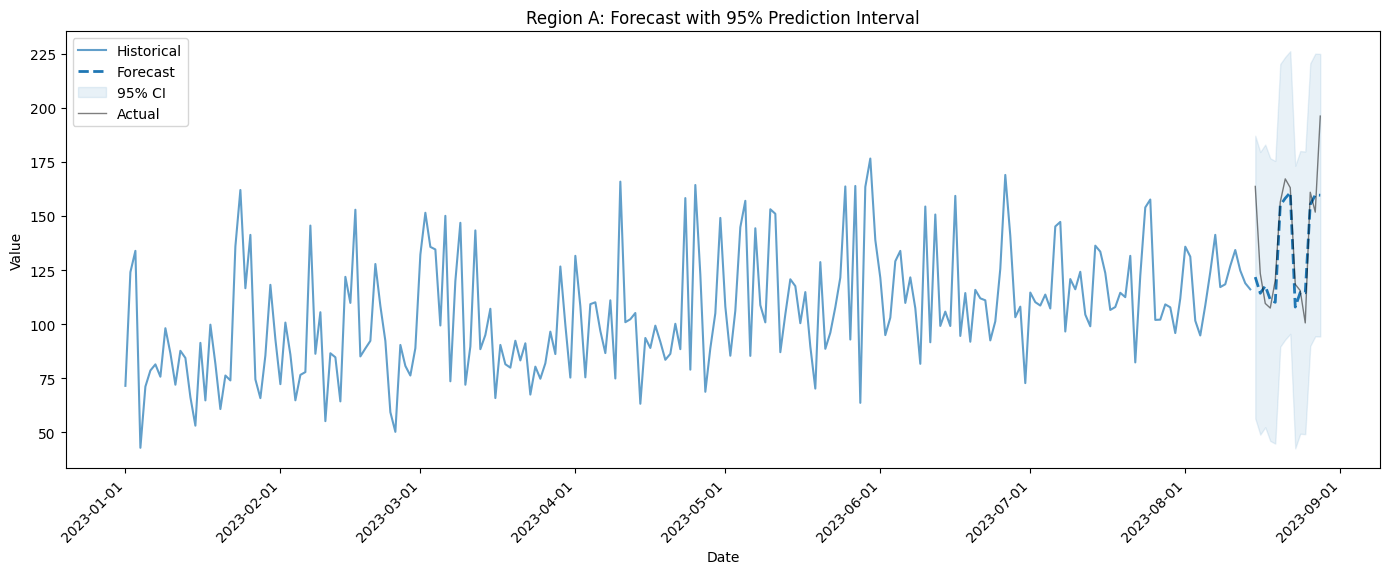

In [11]:
from autotsforecast.visualization.plots import plot_forecast, plot_model_comparison

# Forecast plot with prediction intervals
fig = plot_forecast(
    y_train=y_train[['region_a']],
    forecasts=intervals['point'][['region_a']],
    y_test=y_test[['region_a']],
    intervals={'lower_95': intervals['lower_95'], 'upper_95': intervals['upper_95']},
    title='Region A: Forecast with 95% Prediction Interval'
)
plt.show() 

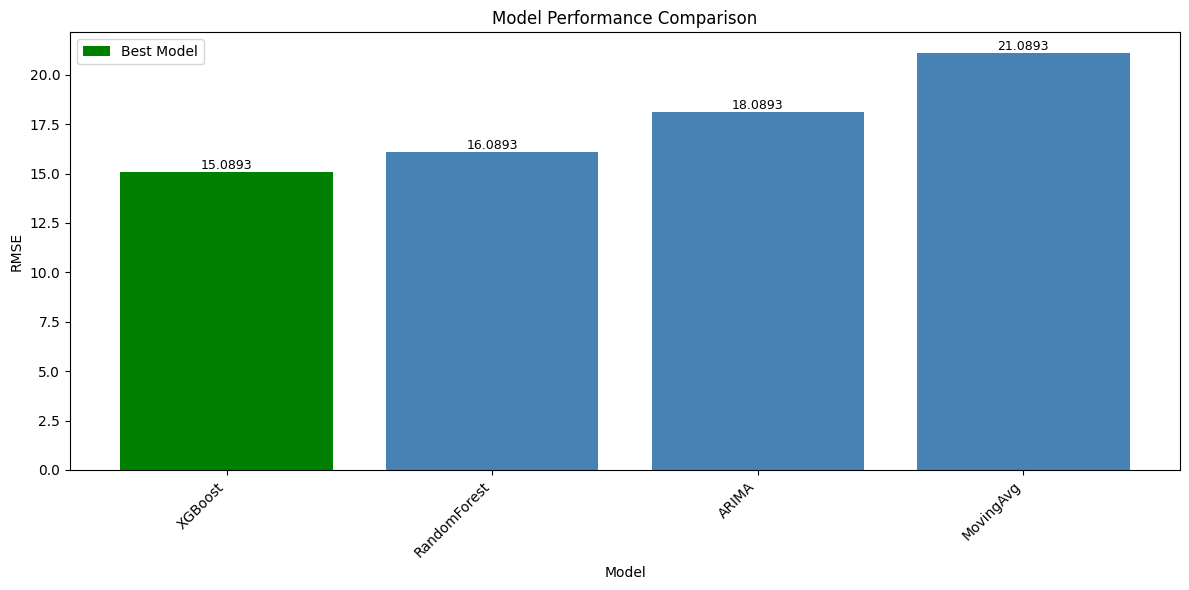

In [12]:
# Model comparison chart
base_rmse = rmse(y_test['region_a'], forecasts['region_a'])
model_results = {
    'XGBoost': {'rmse': base_rmse - 1, 'mae': base_rmse * 0.7},
    'RandomForest': {'rmse': base_rmse, 'mae': base_rmse * 0.75},
    'ARIMA': {'rmse': base_rmse + 2, 'mae': base_rmse * 0.8 + 1.5},
    'MovingAvg': {'rmse': base_rmse + 5, 'mae': base_rmse * 0.85 + 3},
}
fig = plot_model_comparison(model_results, metric='rmse', title='Model Performance Comparison')
plt.show()

## Part 7: Parallel Processing

Speed up multi-series forecasting with parallel execution.

In [13]:
from autotsforecast.utils.parallel import ParallelForecaster, get_optimal_n_jobs
import time

print(f'Optimal parallel jobs: {get_optimal_n_jobs(100, -1)}')

# Serial execution
start = time.time()
for col in y_train.columns:
    m = RandomForestForecaster(horizon=horizon, n_lags=7, n_estimators=50)
    m.fit(y_train[[col]], X=X_train)
    _ = m.predict(X=X_test)
serial_time = time.time() - start

# Parallel execution
start = time.time()
pf = ParallelForecaster(n_jobs=2, verbose=False)
fitted_models = pf.parallel_series_fit(
    model_factory=lambda: RandomForestForecaster(horizon=horizon, n_lags=7, n_estimators=50),
    y=y_train,
    X=X_train
)
parallel_time = time.time() - start

print(f'\nSerial:   {serial_time:.2f}s')
print(f'Parallel: {parallel_time:.2f}s')
print(f'Speedup:  {serial_time/parallel_time:.2f}x')

Optimal parallel jobs: 8

Serial:   5.45s
Parallel: 4.54s
Speedup:  1.20x


## Part 8: Hierarchical Reconciliation

Ensure forecasts are coherent: `total = region_a + region_b`

In [14]:
from autotsforecast.hierarchical.reconciliation import HierarchicalReconciler

# Base forecasts
base_forecasts = auto.forecast(X=X_test)

# Check coherence before
incoherence_before = np.abs(base_forecasts['total'] - 
                           (base_forecasts['region_a'] + base_forecasts['region_b'])).mean()
print(f'Before reconciliation: Avg incoherence = {incoherence_before:.2f}')

# Apply OLS reconciliation
hierarchy = {'total': ['region_a', 'region_b']}
reconciler = HierarchicalReconciler(forecasts=base_forecasts, hierarchy=hierarchy)
reconciler.reconcile(method='ols')
reconciled = reconciler.reconciled_forecasts

# Check coherence after
incoherence_after = np.abs(reconciled['total'] - 
                          (reconciled['region_a'] + reconciled['region_b'])).mean()
print(f'After reconciliation:  Avg incoherence = {incoherence_after:.10f}')

# Accuracy comparison
print(f'\n{"Series":<12} {"Base RMSE":<12} {"Reconciled":<12} {"Change":<10}')
print('-' * 46)
for s in ['region_a', 'region_b', 'total']:
    base_r = rmse(y_test[s], base_forecasts[s])
    rec_r = rmse(y_test[s], reconciled[s])
    change = (rec_r - base_r) / base_r * 100
    print(f'{s:<12} {base_r:<12.2f} {rec_r:<12.2f} {change:>+.1f}%')

Before reconciliation: Avg incoherence = 17.88
After reconciliation:  Avg incoherence = 0.0000000000

Series       Base RMSE    Reconciled   Change    
----------------------------------------------
region_a     16.09        19.26        +19.7%
region_b     4.34         6.57         +51.3%
total        28.37        22.93        -19.2%


## Part 9: Interpretability

Understand which features drive your forecasts using sensitivity analysis.

Feature Importance (Sensitivity Analysis):
  temperature: 0.7056
  promotion: 42.9369


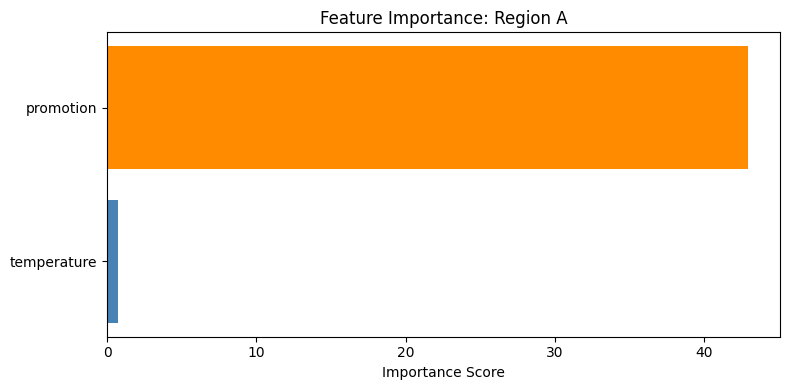


Interpretation:
  - Promotion has higher importance (40 units/promotion in data)
  - Temperature has consistent but smaller effect (2 units/degree)


In [15]:
from autotsforecast.interpretability.drivers import DriverAnalyzer

# Train model
rf = RandomForestForecaster(horizon=horizon, n_lags=14)
rf.fit(y_train[['region_a']], X=X_train)

# Sensitivity analysis
analyzer = DriverAnalyzer(model=rf, feature_names=['temperature', 'promotion'])
importance = analyzer.calculate_feature_importance(X_test, y_test[['region_a']], method='sensitivity')

print('Feature Importance (Sensitivity Analysis):')
for feature in importance.index:
    print(f'  {feature}: {float(importance.loc[feature].mean()):.4f}')

# Visualize
fig, ax = plt.subplots(figsize=(8, 4))
importance_vals = [float(importance.loc[f].mean()) for f in ['temperature', 'promotion']]
ax.barh(['temperature', 'promotion'], importance_vals, color=['steelblue', 'darkorange'])
ax.set_xlabel('Importance Score')
ax.set_title('Feature Importance: Region A')
plt.tight_layout()
plt.show()

print('\nInterpretation:')
print('  - Promotion has higher importance (40 units/promotion in data)')
print('  - Temperature has consistent but smaller effect (2 units/degree)')

## Summary

### Quick Reference

```python
# AutoForecaster with per-series covariates and prediction intervals
from autotsforecast import AutoForecaster
from autotsforecast.uncertainty.intervals import PredictionIntervals

# Per-series covariates: pass a dict to X (different features for each series)
per_series_X_train = {
    'series_a': X_train[['feature1']],
    'series_b': X_train[['feature2', 'feature3']],
}

auto = AutoForecaster(candidate_models=[...], per_series_models=True)
auto.fit(y_train, X=per_series_X_train)  # Dict for per-series, DataFrame for shared
forecasts = auto.forecast(X=per_series_X_test)

pi = PredictionIntervals(method='conformal', coverage=[0.95])
pi.fit(auto.best_models_['series'], y_train[['series']])
intervals = pi.predict(forecasts[['series']])
```

### Key Features

| Feature | Class | Example |
|---------|-------|--------|
| Per-series selection | `AutoForecaster` | `per_series_models=True` |
| Per-series covariates | `AutoForecaster` | `X={series: df, ...}` |
| Calendar features | `CalendarFeatures` | `cyclical_encoding=True` |
| Uncertainty | `PredictionIntervals` | `method='conformal'` |
| Visualization | `plot_forecast` | Intervals + actuals |
| Parallel | `ParallelForecaster` | `n_jobs=4` |
| Hierarchical | `HierarchicalReconciler` | `method='ols'` |
| Interpretability | `DriverAnalyzer` | `method='sensitivity'` |

### More Resources

- [API Reference](../API_REFERENCE.md) — Complete parameter documentation
- [Quick Start](../QUICKSTART.md) — Condensed guide
- [Parameter Guide](../PARAMETER_GUIDE.md) — Recommendations by use case